# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import contextily as ctx
from shapely.ops import cascaded_union
# https://github.com/WZBSocialScienceCenter/geovoronoi
from geovoronoi import voronoi_regions_from_coords
from geovoronoi import points_to_coords
import seaborn as sns
from shapely.geometry import Point

# 0. Telefonica Antenna dataset transformation
Original file is in tsv (tab separate value format) without header, but I was able to come across the header from somwhere/somehow - I can't recall when/from who. The file is also in 'EPSG:7405 - OSGB 1936 / British National Grid' format. Again I am not sure how I found it out - maybe QGIS automatically detected it?

In [2]:
telefonica_antenna_location = 'datasets/Telefonica_Antenna/Antenna.tsv'
header = ['csr', 'cell_id', 'sector', 'mi_mycom_id', 'generation', 'wcel_id', 'fdd', 'model_name', 
          'site_name', 'site_type', 'cell_type', 'manufacturer', 'lacod', 'ne_id', 'msc', 'cell_carriers', 
          'cell_3g_carrier', 'cell_of_origin', 'zone_code', 'adr1', 'adr2', 'adr3', 'town', 'country', 
          'postcode', 'easting', 'northing', 'bcch', 'arfcn', 'trx_list', 'ncc', 'bcc', 'scc', 'sac', 
          'rac', 'tma', 'environment', 'kit_type', 'antenna_num', 'beam_width', 'ant_name', 'ant_height', 
          'ground_height', 'tilt', 'elec_tilt', 'azimuth', 'power', 'losses', 'area', 'region', 'bis_date', 
          'site_generation_type', 'cell_owner', 'jv_id', 'enodeb_id', 'pci', 'tac', 'rsi', 'ura', 'enodebname', 
          'databuild_dttm', 'lkey', 'dt', 'google_cluster_id', 'field_65']

In [3]:
telefonica_antenna_pd = pd.read_csv(telefonica_antenna_location, sep='\t', names=header)
telefonica_antenna_pd = telefonica_antenna_pd[['generation','lkey','easting','northing','town']]

geometry = [Point(xy) for xy in zip(telefonica_antenna_pd.easting, telefonica_antenna_pd.northing)]
telefonica_antenna_pd = telefonica_antenna_pd.drop(['easting', 'northing'],axis=1)
crs = {'init': 'epsg:7405'}
telefonica_antenna_gpd = gpd.GeoDataFrame(telefonica_antenna_pd, crs=crs, geometry=geometry)
# we temporarily convert it to 4326 CRS as that is the CRS of LSOA dataset - in case somebody want to play with it in QGIS
#telefonica_antenna_gpd = telefonica_antenna_gpd.to_crs(epsg=4326)
telefonica_antenna_gpd = telefonica_antenna_gpd.to_crs(epsg=3857)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3,4,6,7,8,9,10,11,19,20,21,22,23,28,29,36,37,40,48,49,50,51,52,53,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print('Number of all antennas in the dataset: ' + str(len(telefonica_antenna_gpd)))
print('Number of antennas that do not have coordinates: ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.geometry.type!='Point'])))
print('Unique values in antenna generation column: ' + str(telefonica_antenna_gpd.generation.unique()))
print('Number of antennas with 2G Generation values: ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.generation == '2G'])))
print('Number of antennas with 3G Generation values: ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.generation == '3G'])))
print('Number of antennas with 4G Generation values: ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.generation == '4G'])))
print('Number of antennas with 5G Generation values: ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.generation == '5G'])))
print('Number of antennas with empty Generation values: ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.generation.isna()])))
print('Number of duplicate antennas (sometimes there are 2 entries with additional informaiton for same antenna): ' + str(len(telefonica_antenna_gpd[telefonica_antenna_gpd.lkey.duplicated()])))

Number of all antennas in the dataset: 345299
Number of antennas that do not have coordinates: 0
Unique values in antenna generation column: ['2G' '3G' '4G' '5G' nan]
Number of antennas with 2G Generation values: 49799
Number of antennas with 3G Generation values: 118203
Number of antennas with 4G Generation values: 93853
Number of antennas with 5G Generation values: 1674
Number of antennas with empty Generation values: 81770
Number of duplicate antennas (sometimes there are 2 entries with additional informaiton for same antenna): 44074


In [7]:
# fill missing generation cells with 'None' string so we can filter it out easily afterwards
telefonica_antenna_gpd.generation.fillna('None', inplace=True)
# drop unneeded duplicates
telefonica_antenna_gpd.drop_duplicates(['lkey'], keep='first', inplace=True)
telefonica_antenna_gpd.to_file('datasets/Telefonica_Antenna/telefonica_antenna_uk_EPSG4326-WGS84.geojson', driver='GeoJSON')

In [8]:
telefonica_antenna_gpd.head()

,generation,lkey,town,geometry
0,2G,10001-21106,London,POINT (-9707.155144458935 6712456.411646104)
1,3G,21032-10759,London,POINT (-9707.155144458935 6712456.411646104)
3,2G,20001-21106,London,POINT (-9707.155144458935 6712456.411646104)
4,3G,21032-20759,London,POINT (-9707.155144458935 6712456.411646104)
6,2G,30001-21106,London,POINT (-9707.155144458935 6712456.411646104)


# 1. Dataset preprocessing

In [9]:
telefonica_antenna_gpd_location = 'datasets/Telefonica_Antenna/telefonica_antenna_uk_EPSG4326-WGS84.geojson'
# from UK gov http://data-communities.opendata.arcgis.com/datasets/lower-super-output-area-lsoa-imd2019-wgs84
lsoa_2019_gpd_loc = 'datasets/UK_LSOA/Lower_Super_Output_Area_LSOA_IMD2019__WGS84.geojson'

telefonica_antenna_gpd = gpd.read_file(telefonica_antenna_gpd_location)
# filter generation of antennas we will use
#telefonica_antenna_gpd = telefonica_antenna_gpd[(telefonica_antenna_gpd['generation']=='3G') | (telefonica_antenna_gpd['generation']=='4G') | (telefonica_antenna_gpd['generation']=='5G')]
#telefonica_antenna_gpd = telefonica_antenna_gpd[(telefonica_antenna_gpd['generation']=='4G') | (telefonica_antenna_gpd['generation']=='5G')]
lsoa_2019_gpd = gpd.read_file(lsoa_2019_gpd_loc)

# gpds have to be converted to epsg 3857 as that is the basemap coordinate system (background map in plots)
telefonica_antenna_gpd = telefonica_antenna_gpd.to_crs(epsg=3857)
lsoa_2019_gpd = lsoa_2019_gpd.to_crs(epsg=3857)

In [10]:
# list of London boroughs from https://web.archive.org/web/20101010011530/http://londoncouncils.gov.uk/londonlocalgovernment/londonboroughs.htm
# list elements must end with space ' ' as there is Brent(London) and Brentwood(non-London) LSOA
london_counties = ['Camden ', 'City of London ', 'Hackney ', 'Hammersmith and Fulham ', 'Haringey ', 'Islington ', 'Kensington and Chelsea ', 'Lambeth ', 'Lewisham ', 'Newham ', 'Southwark ', 'Tower Hamlets ', 'Wandsworth ', 'Westminster ', 'Barking and Dagenham ', 'Barnet ', 'Bexley ', 'Brent ', 'Bromley ', 'Croydon ', 'Ealing ', 'Enfield ', 'Greenwich ', 'Harrow', 'Havering', 'Hillingdon ', 'Hounslow ', 'Kingston upon Thames ', 'Merton ', 'Redbridge ', 'Richmond upon Thames ', 'Sutton ', 'Waltham Forest ']
# https://en.wikipedia.org/wiki/Liverpool_Urban_Area vs metropolitan
#same for Birmingham
london_lsoa_2019_gpd = lsoa_2019_gpd[lsoa_2019_gpd['lsoa11nm'].str.match('|'.join(london_counties))][['IMDDecil','geometry']]
birmingham_lsoa_2019_gpd = lsoa_2019_gpd[lsoa_2019_gpd['lsoa11nm'].str.contains('Birmingham')][['IMDDecil','geometry']]
liverpool_lsoa_2019_gpd = lsoa_2019_gpd[lsoa_2019_gpd['lsoa11nm'].str.contains('Liverpool')][['IMDDecil','geometry']]

london_lsoa_2019_gpd.to_file('datasets/UK_LSOA/london_lsoa_2019_gpd.geojson', driver='GeoJSON')
birmingham_lsoa_2019_gpd.to_file('datasets/UK_LSOA/birmingham_lsoa_2019_gpd.geojson', driver='GeoJSON')
liverpool_lsoa_2019_gpd.to_file('datasets/UK_LSOA/liverpool_lsoa_2019_gpd.geojson', driver='GeoJSON')

In [11]:
london_lsoa_2019_gpd = gpd.read_file('datasets/UK_LSOA/london_lsoa_2019_gpd.geojson')
birmingham_lsoa_2019_gpd = gpd.read_file('datasets/UK_LSOA/birmingham_lsoa_2019_gpd.geojson')
liverpool_lsoa_2019_gpd = gpd.read_file('datasets/UK_LSOA/liverpool_lsoa_2019_gpd.geojson')

# 2. UK LSOAs with IMD values for 3 largest cities

C:\ProgramData\Anaconda3\lib\site-packages\contextily\tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


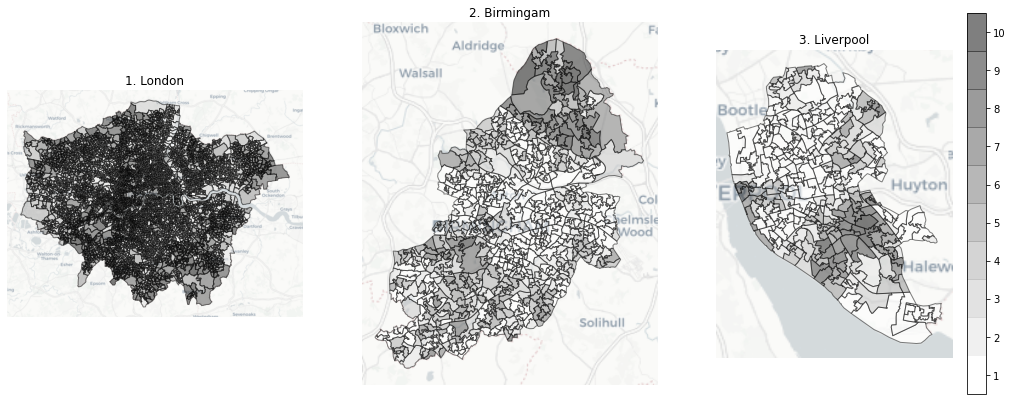

In [12]:
def add_basemap(ax, zoom, url="http://a.basemaps.cartocdn.com/light_all/tileZ/tileX/tileY.png"):#url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

#plot LSOAs with IMD deciles represented by shades of grey
fig, ax = plt.subplots(figsize=(18,10), facecolor='w', edgecolor='k')

ax = plt.subplot(1,3,1)
plt.title('1. London',fontsize=12)
LSOA_polygons = london_lsoa_2019_gpd.plot(ax=ax,alpha = 0.5, column='IMDDecil',cmap=plt.cm.get_cmap('binary', 10),edgecolor='black')
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,2)
plt.title('2. Birmingam',fontsize=12)
LSOA_polygons = birmingham_lsoa_2019_gpd.plot(ax=ax,alpha = 0.5, column='IMDDecil',cmap=plt.cm.get_cmap('binary', 10),edgecolor='black')
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,3)
plt.title('3. Liverpool',fontsize=12)
LSOA_polygons = liverpool_lsoa_2019_gpd.plot(ax=ax,alpha = 0.5, column='IMDDecil',cmap=plt.cm.get_cmap('binary', 10),edgecolor='black')
cbar = plt.colorbar(LSOA_polygons.collections[0], shrink=0.7, ticks=[1.45,2.35,3.25,4.15,5.05,5.95,6.85,7.75,8.65,9.55])
cbar.ax.set_yticklabels(['1','2','3','4','5','6','7','8','9','10'])
add_basemap(ax, zoom=10)
ax.set_axis_off()

# 3. O2 Telefonica antennas within LSOA boundaries

In [13]:
# define boundaries of cities
london_lsoa_2019_boundary = gpd.GeoSeries(cascaded_union(london_lsoa_2019_gpd.buffer(0)))
birmingham_lsoa_2019_boundary = gpd.GeoSeries(cascaded_union(birmingham_lsoa_2019_gpd.buffer(0)))
liverpool_lsoa_2019_boundary = gpd.GeoSeries(cascaded_union(liverpool_lsoa_2019_gpd.buffer(0)))
# we have to create gpds for sjoin (spatial join)
london_lsoa_2019_boundary_gpd = gpd.GeoDataFrame(crs={'init': 'epsg:3857'},geometry=london_lsoa_2019_boundary)
birmingham_lsoa_2019_boundary_gpd = gpd.GeoDataFrame(crs={'init': 'epsg:3857'},geometry=birmingham_lsoa_2019_boundary)
liverpool_lsoa_2019_boundary_gpd = gpd.GeoDataFrame(crs={'init': 'epsg:3857'},geometry=liverpool_lsoa_2019_boundary)

In [14]:
london_lsoa_2019_boundary_gpd.to_file('datasets/UK_LSOA/london_lsoa_2019_boundary.geojson', driver='GeoJSON')
birmingham_lsoa_2019_boundary_gpd.to_file('datasets/UK_LSOA/birmingham_lsoa_2019_boundary.geojson', driver='GeoJSON')
liverpool_lsoa_2019_boundary_gpd.to_file('datasets/UK_LSOA/liverpool_lsoa_2019_boundary.geojson', driver='GeoJSON')

In [15]:
# geopandas sjoin is faster than other methods and direct geometry.intersects/within does not work as expected(does not iterate through whole dataset)
# new datafram contains unnecessary column 'index_right' pointing to only multipolygon in right dataset
telefonica_antenna_london_gpd = sjoin(telefonica_antenna_gpd,london_lsoa_2019_boundary_gpd, how='inner',op='intersects').drop(columns=['index_right']).reset_index(drop=True)
telefonica_antenna_birmingham_gpd = sjoin(telefonica_antenna_gpd,birmingham_lsoa_2019_boundary_gpd, how='inner',op='intersects').drop(columns=['index_right']).reset_index(drop=True)
telefonica_antenna_liverpool_gpd = sjoin(telefonica_antenna_gpd,liverpool_lsoa_2019_boundary_gpd, how='inner',op='intersects').drop(columns=['index_right']).reset_index(drop=True)

#telefonica_antenna_london_gpd.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_gpd.geojson', driver='GeoJSON')
#telefonica_antenna_birmingham_gpd.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_gpd.geojson', driver='GeoJSON')
#telefonica_antenna_liverpool_gpd.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_gpd.geojson', driver='GeoJSON')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3857', 'no_defs': True} != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [17]:
telefonica_antenna_london_gpd = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_gpd.geojson')
telefonica_antenna_birmingham_gpd = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_gpd.geojson')
telefonica_antenna_liverpool_gpd = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_gpd.geojson')

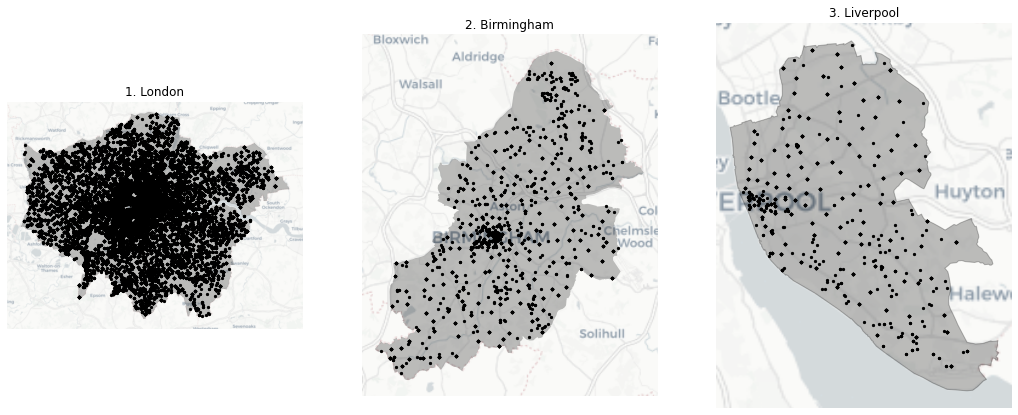

In [18]:
def add_basemap(ax, zoom, url="http://a.basemaps.cartocdn.com/light_all/tileZ/tileX/tileY.png"):#url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

#plot LSOAs with IMD deciles represented by shades of grey
fig, ax = plt.subplots(figsize=(18,10), facecolor='w', edgecolor='k')

ax = plt.subplot(1,3,1)
plt.title('1. London',fontsize=12)
boundary = london_lsoa_2019_boundary_gpd.plot(ax=ax,alpha = 0.25, color='black')
points = telefonica_antenna_london_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,2)
plt.title('2. Birmingham',fontsize=12)
boundary = birmingham_lsoa_2019_boundary_gpd.plot(ax=ax,alpha = 0.25, color='black')
points = telefonica_antenna_birmingham_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,3)
plt.title('3. Liverpool',fontsize=12)
boundary = liverpool_lsoa_2019_boundary_gpd.plot(ax=ax,alpha = 0.25, color='black',edgecolor='black')
points = telefonica_antenna_liverpool_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

# 4. Antenna Voronoi tessellation

In [57]:
# pieces from https://github.com/WZBSocialScienceCenter/geovoronoi
# I don't need extra information, only voronoi tesselation - I commented out lines 69-78 so I have only poly_shapes in return
# only unique coordinates -> faster computation

coords = np.unique(points_to_coords(telefonica_antenna_london_gpd.geometry), axis=0)
poly_shapes = voronoi_regions_from_coords(coords, london_lsoa_2019_boundary_gpd.geometry[0], shapes_from_diff_with_min_area=0.001)
telefonica_antenna_london_gpd_voronoi = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly_shapes))
telefonica_antenna_london_gpd_voronoi.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_gpd_voronoi.geojson', driver='GeoJSON')

coords = np.unique(points_to_coords(telefonica_antenna_birmingham_gpd.geometry), axis=0)
poly_shapes = voronoi_regions_from_coords(coords, birmingham_lsoa_2019_boundary_gpd.geometry[0], shapes_from_diff_with_min_area=0.001)
telefonica_antenna_birmingham_gpd_voronoi = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly_shapes))
telefonica_antenna_birmingham_gpd_voronoi.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_gpd_voronoi.geojson', driver='GeoJSON')

coords = np.unique(points_to_coords(telefonica_antenna_liverpool_gpd.geometry), axis=0)
poly_shapes = voronoi_regions_from_coords(coords, liverpool_lsoa_2019_boundary_gpd.geometry[0], shapes_from_diff_with_min_area=0.001)
telefonica_antenna_liverpool_gpd_voronoi = gpd.GeoDataFrame(geometry=gpd.GeoSeries(poly_shapes))
telefonica_antenna_liverpool_gpd_voronoi.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_gpd_voronoi.geojson', driver='GeoJSON')

In [83]:
telefonica_antenna_london_gpd_voronoi = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_gpd_voronoi.geojson')
telefonica_antenna_birmingham_gpd_voronoi = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_gpd_voronoi.geojson')
telefonica_antenna_liverpool_gpd_voronoi = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_gpd_voronoi.geojson')

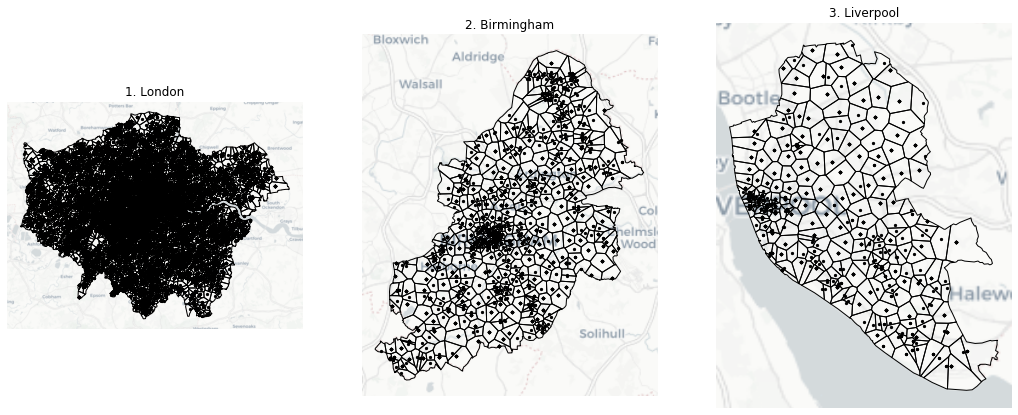

In [58]:
def add_basemap(ax, zoom, url="http://a.basemaps.cartocdn.com/light_all/tileZ/tileX/tileY.png"):#url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

#plot LSOAs with IMD deciles represented by shades of grey
fig, ax = plt.subplots(figsize=(18,10), facecolor='none', edgecolor='none')

ax = plt.subplot(1,3,1)
plt.title('1. London',fontsize=12)
boundaries = telefonica_antenna_london_gpd_voronoi.plot(ax=ax, alpha=1, color='none', edgecolor='black')
points = telefonica_antenna_london_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,2)
plt.title('2. Birmingham',fontsize=12)
boundaries = telefonica_antenna_birmingham_gpd_voronoi.plot(ax=ax, alpha=1, color='none', edgecolor='black')
points = telefonica_antenna_birmingham_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,3)
plt.title('3. Liverpool',fontsize=12)
boundaries = telefonica_antenna_liverpool_gpd_voronoi.plot(ax=ax, alpha=1, color='none', edgecolor='black')
points = telefonica_antenna_liverpool_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

# 5. Assignment of LSOA IMD value to Antenna Voronoi cells based on largest overlap between Voronoi cell and LSOA regions

In [59]:
# the buffer(0) is a mysterious function - I had to use it because of 1 polygon in birgmingham for 345G version- sometime the intersections have issue and buffer(0) resolves it - it's workaround
def get_size_of_intersection(row, right_gpd):
    return row['geometry'].intersection(right_gpd['geometry'].loc[int(row['index_right'])]).area
def get_size_of_intersection_buf(row, right_gpd):
    return row['geometry'].intersection(right_gpd['geometry'].buffer(0).loc[int(row['index_right'])]).area

# 1. we do spatial join to get list of LSOAs that intersects voronoi cells
london_voronoi_vs_lsoa = sjoin(telefonica_antenna_london_gpd_voronoi, london_lsoa_2019_gpd, how='left',op='intersects')
birmingham_voronoi_vs_lsoa = sjoin(telefonica_antenna_birmingham_gpd_voronoi, birmingham_lsoa_2019_gpd, how='left',op='intersects')
liverpool_voronoi_vs_lsoa = sjoin(telefonica_antenna_liverpool_gpd_voronoi, liverpool_lsoa_2019_gpd, how='left',op='intersects')

# 1.1 we adjust the datasets
london_voronoi_vs_lsoa.reset_index(inplace=True)
london_voronoi_vs_lsoa.rename(columns={'index': 'id'}, inplace=True)
birmingham_voronoi_vs_lsoa.reset_index(inplace=True)
birmingham_voronoi_vs_lsoa.rename(columns={'index': 'id'}, inplace=True)
liverpool_voronoi_vs_lsoa.reset_index(inplace=True)
liverpool_voronoi_vs_lsoa.rename(columns={'index': 'id'}, inplace=True)

# 2. we compute interection sizes between voronoi cells and intersected LSOAs
london_voronoi_vs_lsoa['intersection_size'] = london_voronoi_vs_lsoa.apply(lambda row : get_size_of_intersection(row, london_lsoa_2019_gpd), axis=1)
birmingham_voronoi_vs_lsoa['intersection_size'] = birmingham_voronoi_vs_lsoa.apply(lambda row : get_size_of_intersection(row, birmingham_lsoa_2019_gpd), axis=1)
liverpool_voronoi_vs_lsoa['intersection_size'] = liverpool_voronoi_vs_lsoa.apply(lambda row : get_size_of_intersection(row, liverpool_lsoa_2019_gpd), axis=1)

# 3. we filter the max intersection size LSOAs and keep only the IMD decile
# there is no working/usable groupby geopandas at the  moment:
# 3.1 we sort values from high to low (descending)
# 3.2 unite tha values based on id(same for each polygon with same coordinates)
# 3.3 take the first, i.e. highest, intersection value
london_voronoi_vs_lsoa.sort_values(['id', 'intersection_size'], ascending=False, inplace=True)
london_voronoi_vs_lsoa = london_voronoi_vs_lsoa.dissolve('id')
london_voronoi_vs_lsoa.drop(columns=['index_right', 'intersection_size'], inplace=True)
birmingham_voronoi_vs_lsoa.sort_values(['id', 'intersection_size'], ascending=False, inplace=True)
birmingham_voronoi_vs_lsoa = birmingham_voronoi_vs_lsoa.dissolve('id')
birmingham_voronoi_vs_lsoa.drop(columns=['index_right', 'intersection_size'], inplace=True)
liverpool_voronoi_vs_lsoa.sort_values(['id', 'intersection_size'], ascending=False, inplace=True)
liverpool_voronoi_vs_lsoa = liverpool_voronoi_vs_lsoa.dissolve('id')
liverpool_voronoi_vs_lsoa.drop(columns=['index_right', 'intersection_size'], inplace=True)

london_voronoi_vs_lsoa.to_file('datasets/Telefonica_Antenna/XG/london_voronoi_vs_lsoa.geojson', driver='GeoJSON')
birmingham_voronoi_vs_lsoa.to_file('datasets/Telefonica_Antenna/XG/birmingham_voronoi_vs_lsoa.geojson', driver='GeoJSON')
liverpool_voronoi_vs_lsoa.to_file('datasets/Telefonica_Antenna/XG/liverpool_voronoi_vs_lsoa.geojson', driver='GeoJSON')

In [7]:
london_voronoi_vs_lsoa = gpd.read_file('datasets/Telefonica_Antenna/XG/london_voronoi_vs_lsoa.geojson')
birmingham_voronoi_vs_lsoa = gpd.read_file('datasets/Telefonica_Antenna/XG/birmingham_voronoi_vs_lsoa.geojson')
liverpool_voronoi_vs_lsoa = gpd.read_file('datasets/Telefonica_Antenna/XG/liverpool_voronoi_vs_lsoa.geojson')

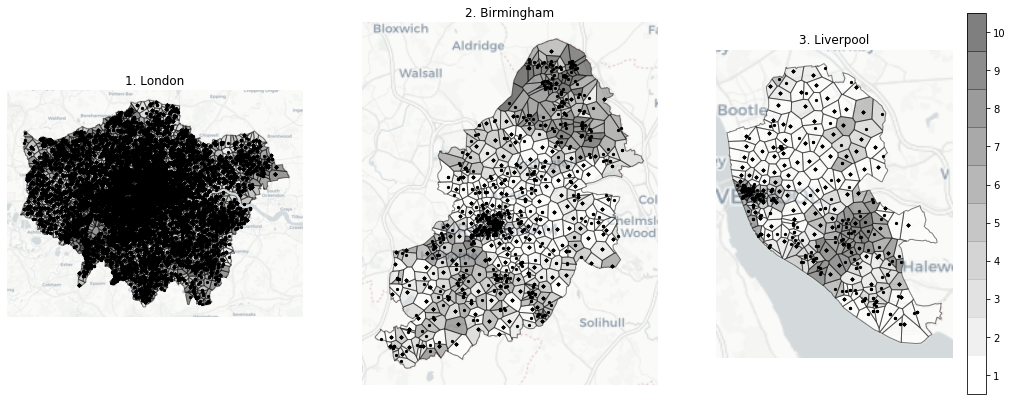

In [61]:
def add_basemap(ax, zoom, url="http://a.basemaps.cartocdn.com/light_all/tileZ/tileX/tileY.png"):#url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

#plot LSOAs with IMD deciles represented by shades of grey
fig, ax = plt.subplots(figsize=(18,10), facecolor='none', edgecolor='none')

ax = plt.subplot(1,3,1)
plt.title('1. London',fontsize=12)
voronoi_imd_polygons = london_voronoi_vs_lsoa.plot(ax=ax,alpha = 0.5, column='IMDDecil',cmap=plt.cm.get_cmap('binary', 10),edgecolor='black')
points = telefonica_antenna_london_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,2)
plt.title('2. Birmingham',fontsize=12)
voronoi_imd_polygons = birmingham_voronoi_vs_lsoa.plot(ax=ax,alpha = 0.5, column='IMDDecil',cmap=plt.cm.get_cmap('binary', 10),edgecolor='black')
points = telefonica_antenna_birmingham_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

ax = plt.subplot(1,3,3)
plt.title('3. Liverpool',fontsize=12)
voronoi_imd_polygons = liverpool_voronoi_vs_lsoa.plot(ax=ax,alpha = 0.5, column='IMDDecil',cmap=plt.cm.get_cmap('binary', 10),edgecolor='black')
cbar = plt.colorbar(voronoi_imd_polygons.collections[0], shrink=0.7, ticks=[1.45,2.35,3.25,4.15,5.05,5.95,6.85,7.75,8.65,9.55])
cbar.ax.set_yticklabels(['1','2','3','4','5','6','7','8','9','10'])
points = telefonica_antenna_liverpool_gpd.plot(ax=ax,alpha = 1, color='black',markersize=5)
add_basemap(ax, zoom=10)
ax.set_axis_off()

# 6. Assignment of LSOA IMD value from Antenna Voronoi cells to each antenna in dataset

In [44]:
telefonica_antenna_london_imd_gpd = sjoin(telefonica_antenna_london_gpd, london_voronoi_vs_lsoa, how='left',op='intersects')
telefonica_antenna_birmingham_imd_gpd = sjoin(telefonica_antenna_birmingham_gpd, birmingham_voronoi_vs_lsoa, how='left',op='intersects')
telefonica_antenna_liverpool_imd_gpd = sjoin(telefonica_antenna_liverpool_gpd, liverpool_voronoi_vs_lsoa, how='left',op='intersects')

# we assign voronoi polygon to each antenna so we have antenna and polygon coordinates, polygon is used later to find out how many 4G polygons are in average within 1 LSOA polygon
telefonica_antenna_london_imd_gpd['geometry_voronoi'] = london_voronoi_vs_lsoa.geometry[telefonica_antenna_london_imd_gpd['index_right'].values].astype(str).values
telefonica_antenna_london_imd_gpd = telefonica_antenna_london_imd_gpd.drop(columns=['index_right'])
telefonica_antenna_birmingham_imd_gpd['geometry_voronoi'] = birmingham_voronoi_vs_lsoa.geometry[telefonica_antenna_birmingham_imd_gpd['index_right'].values].astype(str).values
telefonica_antenna_birmingham_imd_gpd = telefonica_antenna_birmingham_imd_gpd.drop(columns=['index_right'])
telefonica_antenna_liverpool_imd_gpd['geometry_voronoi'] = liverpool_voronoi_vs_lsoa.geometry[telefonica_antenna_liverpool_imd_gpd['index_right'].values].astype(str).values
telefonica_antenna_liverpool_imd_gpd = telefonica_antenna_liverpool_imd_gpd.drop(columns=['index_right'])

telefonica_antenna_london_imd_gpd.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_gpd.geojson', driver='GeoJSON')
telefonica_antenna_birmingham_imd_gpd.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_gpd.geojson', driver='GeoJSON')
telefonica_antenna_liverpool_imd_gpd.to_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_gpd.geojson', driver='GeoJSON')

# for HomeDetection script
telefonica_antenna_london_imd_gpd.to_csv('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv',index=False)
telefonica_antenna_birmingham_imd_gpd.to_csv('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv',index=False)
telefonica_antenna_liverpool_imd_gpd.to_csv('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv',index=False)

telefonica_antenna_liverpool_imd_gpd.head()

,generation,lkey,geometry,IMDDecil,geometry_voronoi
0,2G,08851-8634,POINT (-331739.8479849889 7057970.066658555),6,POLYGON ((-331841.1495779217 7058121.359558538...
1,3G,21880-11860,POINT (-332748.0823947123 7060286.172188723),2,POLYGON ((-333144.1895415643 7059884.135267855...
2,2G,18357-8634,POINT (-332748.0823947123 7060286.172188723),2,POLYGON ((-333144.1895415643 7059884.135267855...
3,3G,21880-21860,POINT (-332748.0823947123 7060286.172188723),2,POLYGON ((-333144.1895415643 7059884.135267855...
4,2G,28357-8634,POINT (-332748.0823947123 7060286.172188723),2,POLYGON ((-333144.1895415643 7059884.135267855...
